In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plta
import matplotlib.ticker as ticker

In [2]:
df = pd.read_csv (r'C:\אריאל\שנה א\סמסטר א\מבוא למדעי הנתונים\עבודת הגמר\Data_Science_intro_project\web_scraping\data.csv', index_col = False)

In [3]:
df.replace('(^\s+|\s+$)', '', regex=True, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9586 entries, 0 to 9585
Columns: 105 entries, שם המוצר to כלורופיל
dtypes: float64(27), int64(74), object(4)
memory usage: 7.7+ MB


In [5]:
df.describe()

,"1 ק""ג",B1 ויטמין,B6 ויטמין,סיבים תזונתיים,חומצה פולית,אנרגיה,חלבונים,פחמימות,נתרן,B3 ויטמין,...,כרום,מוליבדן,1 מטר,100 מטר,בלתי רווי,חומצה לאורית,חומצה לינולאית,DHA,EPA,כלורופיל
count,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9585.000000,9583.000000,9579.000000,9586.000000,...,9586.000000,9586.000000,9586.0,9586.0,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000
mean,0.152237,2.113054,0.014973,2.261719,3.368308,260.235347,7.396335,29.016621,534.951080,0.061139,...,0.008346,0.007928,0.0,0.0,0.001043,0.017108,0.009180,0.146046,0.219069,0.041728
std,2.369205,145.590753,0.186376,4.180566,74.284157,187.766668,15.253779,28.903568,2676.307658,1.003168,...,0.426475,0.388596,0.0,0.0,0.072218,0.837389,0.635516,10.110478,15.165716,2.888708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,102.000000,1.400000,5.000000,18.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,226.000000,5.100000,18.900000,120.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,3.000000,0.000000,382.000000,10.000000,53.000000,400.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,64.900000,10080.000000,9.600000,42.800000,5000.000000,1976.000000,764.000000,625.500000,40000.000000,77.000000,...,26.000000,20.000000,0.0,0.0,5.000000,41.000000,44.000000,700.000000,1050.000000,200.000000


In [6]:
df.head()

,שם המוצר,"1 ק""ג",B1 ויטמין,B6 ויטמין,סיבים תזונתיים,חומצה פולית,אנרגיה,חלבונים,פחמימות,שומנים,...,כרום,מוליבדן,1 מטר,100 מטר,בלתי רווי,חומצה לאורית,חומצה לינולאית,DHA,EPA,כלורופיל
0,קלמנטינה,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12.0,0.2,...,0,0,0,0,0,0,0,0,0,0
1,תפוח עץ מוזהב,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,0.2,...,0,0,0,0,0,0,0,0,0,0
2,לימון,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,0.3,...,0,0,0,0,0,0,0,0,0,0
3,תפוז ברשת למיץ,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,0.3,...,0,0,0,0,0,0,0,0,0,0
4,אבוקדו,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,14.7,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df = df.replace('פחות מ 0.5', '0')
df = df.replace('פחות מ 0.1', '0')
df = df.replace('פחות מ 1', '0')
df = df.replace('פחות מ 0.7', '0')
df = df.replace('פחות מ 2.5', '0')
df = df.replace('פחות מ 1.5', '0')
df = df.replace('פחות מ 5', '0')
df = df.replace('פחות מ 0.65', '0')
df = df.replace('פחות מ 0.2', '0')
df = df.replace('פחות מ 2', '0')
df = df.replace('פחות מ 1.1', '0')
df = df.replace('פחות מ 0', '0')
df = df.replace('פחות מ 0.9', '0')
df = df.replace('פחות מ 0.05', '0')

In [8]:
df['סיבים תזונתיים'] = df['סיבים תזונתיים']+df['סיבים תזונתים'] #found two columns with the same kind of values, typo in one of the column names
df = df.drop(['סיבים תזונתים'], axis = 1)

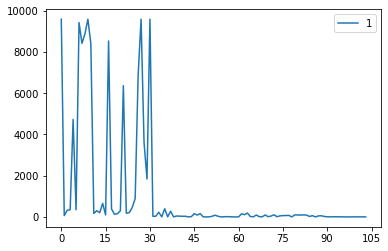

In [9]:
df_num = []
df_name = []
for col in df.columns:
    df_num.append(int(df[col].astype(bool).sum(axis=0)))
    df_name.append(col)
df2 = pd.DataFrame([df_name, df_num]).transpose()
ax = df2.plot(x_compat=True)
ax.xaxis.set_major_locator(ticker.MaxNLocator()) #Dynamically finds major tick positions
plta.show() #in order to check which features can be given up
#it seems that starting from feature number 31, we can give up on those features
#it actually makes sense, because when we did the web scraping, it added to the keys, the names of the columns, 
#a name each time it was not already there. therefore, we would expect the common keys to be at the beginning of the columns

In [10]:
df_new = df.iloc[:,:31] #we'll try creating a new data-set, with only the first 31 features, and put it aside for now
df_new = df_new.set_index('שם המוצר')
df_new

,"1 ק""ג",B1 ויטמין,B6 ויטמין,סיבים תזונתיים,חומצה פולית,אנרגיה,חלבונים,פחמימות,שומנים,נתרן,...,סוכרים מתוך פחמימות,A ויטמין,אבץ,מתוכם סוכר מוסף,"100 מ""ל",מתוכם שומן רווי,חומצות שומן טרנס,כפיות סוכר,סידן,כולסטרול
שם המוצר,,,,,,,,,,,,,,,,,,,,,
קלמנטינה,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12.0,0.2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0
תפוח עץ מוזהב,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,0.2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0
לימון,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,0.3,2.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0
תפוז ברשת למיץ,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,0.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0
אבוקדו,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,14.7,7.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
אב.חלבון מי גבינה ט.וניל,0.0,0.00,0.50,0.0,189.7,137.0,26.0,2.8,2.6,64.0,...,2.0,0.0,0.0,0.0,0.0,1.70,0,0.0,176.6,0
אב.חלבון מי גבינה שוקולד,0.0,0.00,0.49,0.0,186.6,134.0,25.0,2.6,2.6,133.0,...,1.9,0.0,0.0,0.0,0.0,1.75,0,0.0,175.3,0
אבקה חלבון גו טעם,0.0,0.00,0.00,0.8,0.0,125.0,25.0,2.8,1.2,86.0,...,0.7,0.0,0.0,0.0,0.0,1.70,0,0.0,169.0,158


In [11]:
#back with the original dataframe
arr = np.array([])
for col in df.columns:
    if df[col].astype(bool).sum(axis=0)<50: #all the features that less than precent of the products have
        arr = np.append(arr, df[col].to_numpy().nonzero()) 
arr = np.append(arr, df['100 מ"ל'].to_numpy().nonzero()) #all the products that are measured by milliliters
arr = np.append(arr, df['1 ס"מ'].to_numpy().nonzero()) #all the products that are measured by centimeters, making all the solid products being mesuard by the same unit
arr = np.append(arr, df['1 יחידה'].to_numpy().nonzero()) #all the products that are measured by unite
print(arr)
arr = set(arr) #all number of rows without duplicates
df = df.drop(arr)
df = df.loc[:, (df != 0).any(axis=0)] #deletes all columns with all values set to zero
df

[ 142.  347. 3462. ... 9564. 9565. 9566.]


,שם המוצר,"1 ק""ג",B1 ויטמין,B6 ויטמין,סיבים תזונתיים,חומצה פולית,אנרגיה,חלבונים,פחמימות,שומנים,...,נוקלאוטידים,חומצת שומן לינולאית,סלניום,נחושת,טאורין,כולין,אינוסיטול,חומצה אלפא לינולנית,כלור,קרניטין
0,קלמנטינה,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12.0,0.2,...,0,0,0,0,0,0,0,0,0,0
1,תפוח עץ מוזהב,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,0.2,...,0,0,0,0,0,0,0,0,0,0
2,לימון,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,0.3,...,0,0,0,0,0,0,0,0,0,0
3,תפוז ברשת למיץ,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,0.3,...,0,0,0,0,0,0,0,0,0,0
4,אבוקדו,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,14.7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9581,אב.חלבון מי גבינה ט.וניל,0.0,0.00,0.50,0.0,189.7,137.0,26.0,2.8,2.6,...,0,0,0,0,0,0,0,0,0,0
9582,אב.חלבון מי גבינה שוקולד,0.0,0.00,0.49,0.0,186.6,134.0,25.0,2.6,2.6,...,0,0,0,0,0,0,0,0,0,0
9583,אבקה חלבון גו טעם,0.0,0.00,0.00,0.8,0.0,125.0,25.0,2.8,1.2,...,0,0,0,0,0,0,0,0,0,0
9584,אבקה חלבון גו ללא טעם,0.0,0.00,0.00,0.3,0.0,29.0,6.0,0.3,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df.select_dtypes(include=['object'])

,שם המוצר,שומנים,חומצות שומן טרנס,כולסטרול
0,קלמנטינה,0.2,0,0
1,תפוח עץ מוזהב,0.2,0,0
2,לימון,0.3,0,0
3,תפוז ברשת למיץ,0.3,0,0
4,אבוקדו,14.7,0,0
...,...,...,...,...
9581,אב.חלבון מי גבינה ט.וניל,2.6,0,0
9582,אב.חלבון מי גבינה שוקולד,2.6,0,0
9583,אבקה חלבון גו טעם,1.2,0,158
9584,אבקה חלבון גו ללא טעם,0,0,165


In [13]:
def convert_type_to_float(category_name, dataframe):
    listt = []
    for prod in dataframe[category_name]:
        listt.append(float(prod))
    df2 = pd.DataFrame({category_name:listt})
    dataframe = dataframe.drop([category_name], axis = 1)
    return df2

In [14]:
adf = convert_type_to_float('חומצות שומן טרנס', df)
bdf = convert_type_to_float('שומנים', df)
cdf = convert_type_to_float('כולסטרול', df)
df['שומנים'] = bdf
df['חומצות שומן טרנס'] = adf
df['כולסטרול'] = cdf
df = df.fillna(0)

In [15]:
df= df.set_index('שם המוצר')
df

,"1 ק""ג",B1 ויטמין,B6 ויטמין,סיבים תזונתיים,חומצה פולית,אנרגיה,חלבונים,פחמימות,שומנים,נתרן,...,נוקלאוטידים,חומצת שומן לינולאית,סלניום,נחושת,טאורין,כולין,אינוסיטול,חומצה אלפא לינולנית,כלור,קרניטין
שם המוצר,,,,,,,,,,,,,,,,,,,,,
קלמנטינה,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12.0,0.2,1.0,...,0,0,0,0,0,0,0,0,0,0
תפוח עץ מוזהב,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,0.2,1.0,...,0,0,0,0,0,0,0,0,0,0
לימון,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,0.3,2.0,...,0,0,0,0,0,0,0,0,0,0
תפוז ברשת למיץ,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,0.3,0.0,...,0,0,0,0,0,0,0,0,0,0
אבוקדו,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,14.7,7.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
אב.חלבון מי גבינה ט.וניל,0.0,0.00,0.50,0.0,189.7,137.0,26.0,2.8,0.0,64.0,...,0,0,0,0,0,0,0,0,0,0
אב.חלבון מי גבינה שוקולד,0.0,0.00,0.49,0.0,186.6,134.0,25.0,2.6,0.0,133.0,...,0,0,0,0,0,0,0,0,0,0
אבקה חלבון גו טעם,0.0,0.00,0.00,0.8,0.0,125.0,25.0,2.8,0.0,86.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df = df.fillna(0)
corr_matrix = df.corr()
corr_matrix['שומנים'].sort_values(ascending=False)

שומנים                         1.000000
כולסטרול                       0.234098
חומצות שומן טרנס               0.125626
כפיות סוכר                     0.109514
אנרגיה                         0.091189
סוכרים מתוך פחמימות            0.074875
סידן                           0.052048
פחמימות                        0.033661
חלבונים                        0.023401
מתוכם שומן רווי                0.020176
חומצה אסקורבית                 0.019240
סוכרים                         0.019064
B2 ויטמין                      0.015841
B1 ויטמין                      0.015840
חומצות שומן רווי               0.013426
ניאצין                         0.012736
ביוטין                         0.011048
חומצה פולית                    0.009839
זרחן                           0.006460
100 גרם                        0.005838
יוד                            0.005324
B6 ויטמין                      0.003530
נתרן                          -0.001713
K ויטמין                      -0.006802
קרניטין                       -0.007098


In [17]:
df = df.loc[:, (df != 0).any(axis=0)] #deletes all columns with all values set to zero

In [18]:
df.astype(bool).sum(axis=0)

1 ק"ג                            63
B1 ויטמין                       166
B6 ויטמין                       198
סיבים תזונתיים                 4323
חומצה פולית                     199
אנרגיה                         8158
חלבונים                        7451
פחמימות                        7802
שומנים                         6032
נתרן                           7355
B3 ויטמין                       110
אשלגן                           200
C ויטמין                        106
ברזל                            504
100 גרם                        8236
B2 ויטמין                       176
K ויטמין                         31
E ויטמין                         57
מגנזיום                         195
סוכרים מתוך פחמימות            5593
A ויטמין                         83
אבץ                              80
מתוכם סוכר מוסף                 357
מתוכם שומן רווי                6045
חומצות שומן טרנס                642
כפיות סוכר                     3196
סידן                           1374
כולסטרול                    

In [19]:
df

,"1 ק""ג",B1 ויטמין,B6 ויטמין,סיבים תזונתיים,חומצה פולית,אנרגיה,חלבונים,פחמימות,שומנים,נתרן,...,נוקלאוטידים,חומצת שומן לינולאית,סלניום,נחושת,טאורין,כולין,אינוסיטול,חומצה אלפא לינולנית,כלור,קרניטין
שם המוצר,,,,,,,,,,,,,,,,,,,,,
קלמנטינה,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12.0,0.2,1.0,...,0,0,0,0,0,0,0,0,0,0
תפוח עץ מוזהב,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,0.2,1.0,...,0,0,0,0,0,0,0,0,0,0
לימון,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,0.3,2.0,...,0,0,0,0,0,0,0,0,0,0
תפוז ברשת למיץ,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,0.3,0.0,...,0,0,0,0,0,0,0,0,0,0
אבוקדו,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,14.7,7.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
אב.חלבון מי גבינה ט.וניל,0.0,0.00,0.50,0.0,189.7,137.0,26.0,2.8,0.0,64.0,...,0,0,0,0,0,0,0,0,0,0
אב.חלבון מי גבינה שוקולד,0.0,0.00,0.49,0.0,186.6,134.0,25.0,2.6,0.0,133.0,...,0,0,0,0,0,0,0,0,0,0
אבקה חלבון גו טעם,0.0,0.00,0.00,0.8,0.0,125.0,25.0,2.8,0.0,86.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df[(df['כפיות סוכר']!=0) & (df['סוכרים מתוך פחמימות']!=0)]
column_1 = df["כפיות סוכר"]
column_2 = df["סוכרים מתוך פחמימות"]
correlation = column_1.corr(column_2)
print(correlation) #the correlation between "כפיות סוכר" and "סוכרים מתוך פחמימות" is high, beacuse as we found at https://www.camoni.co.il/411804/559434, a nutritionist named Marina Broshi explained that כפיות סוכר = סוכרים מתוך פחמימות/4, thus, we can give up on the כפיות סוכר column
df = df.drop(['כפיות סוכר'], axis=1) 

0.7482611251105518


In [21]:
from sklearn.feature_selection import VarianceThreshold
def variance_threshold_selector(data, threshold=(0.8 * (1 - .8))):
    selector = VarianceThreshold(threshold) #VarianceThreshold removes all low-variance features.
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [22]:
df = variance_threshold_selector(df, threshold=(0.8 * (1 - .8)))
df

,"1 ק""ג",B1 ויטמין,סיבים תזונתיים,חומצה פולית,אנרגיה,חלבונים,פחמימות,שומנים,נתרן,B3 ויטמין,...,חומצות שומן רווי,ביוטין,יוד,זרחן,מנגן,חומצה אסקורבית,חומצת שומן לינולאית,נחושת,חומצה אלפא לינולנית,כלור
שם המוצר,,,,,,,,,,,,,,,,,,,,,
קלמנטינה,5.9,0.09,1.7,24.0,47.0,9.0,12.0,0.2,1.0,0.6,...,0,0,0,0,0,0,0,0,0,0
תפוח עץ מוזהב,10.9,0.00,2.4,0.0,52.0,0.3,13.8,0.2,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
לימון,6.9,0.00,2.8,0.0,29.0,1.1,9.3,0.3,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
תפוז ברשת למיץ,4.9,0.09,2.5,39.0,49.0,1.0,11.9,0.3,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
אבוקדו,9.9,0.07,6.7,81.0,160.0,2.0,8.5,14.7,7.0,1.7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
אב.חלבון מי גבינה ט.וניל,0.0,0.00,0.0,189.7,137.0,26.0,2.8,0.0,64.0,0.0,...,0,0,0,0,0,0,0,0,0,0
אב.חלבון מי גבינה שוקולד,0.0,0.00,0.0,186.6,134.0,25.0,2.6,0.0,133.0,0.0,...,0,0,0,0,0,0,0,0,0,0
אבקה חלבון גו טעם,0.0,0.00,0.8,0.0,125.0,25.0,2.8,0.0,86.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df_new = variance_threshold_selector(df_new, threshold=(0.8 * (1 - .8)))
df_new #noticed that only one feature fell in this data set!

,"1 ק""ג",B1 ויטמין,סיבים תזונתיים,חומצה פולית,אנרגיה,חלבונים,פחמימות,שומנים,נתרן,B3 ויטמין,...,סוכרים מתוך פחמימות,A ויטמין,אבץ,מתוכם סוכר מוסף,"100 מ""ל",מתוכם שומן רווי,חומצות שומן טרנס,כפיות סוכר,סידן,כולסטרול
שם המוצר,,,,,,,,,,,,,,,,,,,,,
קלמנטינה,5.9,0.09,1.7,24.0,47.0,9.0,12.0,0.2,1.0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0
תפוח עץ מוזהב,10.9,0.00,2.4,0.0,52.0,0.3,13.8,0.2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0
לימון,6.9,0.00,2.8,0.0,29.0,1.1,9.3,0.3,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0
תפוז ברשת למיץ,4.9,0.09,2.5,39.0,49.0,1.0,11.9,0.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0
אבוקדו,9.9,0.07,6.7,81.0,160.0,2.0,8.5,14.7,7.0,1.7,...,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
אב.חלבון מי גבינה ט.וניל,0.0,0.00,0.0,189.7,137.0,26.0,2.8,2.6,64.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.70,0,0.0,176.6,0
אב.חלבון מי גבינה שוקולד,0.0,0.00,0.0,186.6,134.0,25.0,2.6,2.6,133.0,0.0,...,1.9,0.0,0.0,0.0,0.0,1.75,0,0.0,175.3,0
אבקה חלבון גו טעם,0.0,0.00,0.8,0.0,125.0,25.0,2.8,1.2,86.0,0.0,...,0.7,0.0,0.0,0.0,0.0,1.70,0,0.0,169.0,158


In [24]:
for col in df.columns:
    print(col, df[col].astype(bool).sum(axis=0))

1 ק"ג 63
B1 ויטמין 166
סיבים תזונתיים 4323
חומצה פולית 199
אנרגיה 8158
חלבונים 7451
פחמימות 7802
שומנים 6032
נתרן 7355
B3 ויטמין 110
אשלגן 200
C ויטמין 106
ברזל 504
100 גרם 8236
B2 ויטמין 176
K ויטמין 31
E ויטמין 57
מגנזיום 195
סוכרים מתוך פחמימות 5593
A ויטמין 83
אבץ 80
מתוכם סוכר מוסף 357
מתוכם שומן רווי 6045
חומצות שומן טרנס 642
סידן 1374
כולסטרול 2094
סוכרים 140
רב כהלים 386
D ויטמין 61
ניאצין 55
חומצות שומן רווי 81
ביוטין 34
יוד 17
זרחן 79
מנגן 11
חומצה אסקורבית 55
חומצת שומן לינולאית 6
נחושת 21
חומצה אלפא לינולנית 10
כלור 6


In [25]:
for col in df_new.columns:
    print(col, df_new[col].astype(bool).sum(axis=0))

1 ק"ג 63
B1 ויטמין 321
סיבים תזונתיים 4726
חומצה פולית 349
אנרגיה 9426
חלבונים 8417
פחמימות 8879
שומנים 9586
נתרן 8404
B3 ויטמין 171
אשלגן 300
C ויטמין 206
ברזל 655
1 יחידה 98
100 גרם 8531
B2 ויטמין 386
K ויטמין 128
E ויטמין 157
מגנזיום 298
סוכרים מתוך פחמימות 6363
A ויטמין 178
אבץ 208
מתוכם סוכר מוסף 454
100 מ"ל 891
מתוכם שומן רווי 6846
חומצות שומן טרנס 9586
כפיות סוכר 3616
סידן 1839
כולסטרול 9586
